In [12]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import matplotlib.pyplot as plt


def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)


In [13]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

def load_2D(is_valid=True):
    data = np.load('/content/gdrive/My Drive/4-2/ECE421/data2D.npy')
    [num_pts, dim] = data.shape
    
    # getting validation set
    if is_valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        train_data = data[rnd_idx[valid_batch:]]
        return train_data, val_data
    else:
        return data
    
def load_100D(is_valid=True):
    data =  np.load('/content/gdrive/My Drive/4-2/ECE421/data100D.npy')
    [num_pts, dim] = data.shape
    
    # getting validation set
    if is_valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        train_data = data[rnd_idx[valid_batch:]]
        return train_data, val_data
    else:
        return data

Mounted at /content/gdrive


In [14]:
def distance_func(X, mu):
    """ Inputs:
          X: is an NxD matrix (N observations and D dimensions)
          mu: is an KxD matrix (K means and D dimensions)
          
        Output:
          pair_dist: is the squared pairwise distance matrix (NxK)
    """
    X = tf.expand_dims(X, 1)
    mu = tf.expand_dims(mu, 0)
    pair_dist = tf.reduce_sum(tf.square(tf.subtract(X, mu)), 2)
    
    return pair_dist

In [15]:
def find_loss(X, MU):
  pair_dist = distance_func(X, MU)
  mins = tf.reduce_min(pair_dist, 1)
  loss = tf.reduce_sum(mins, 0)
  return loss

def get_cluster(K, MU, X):
    #  getting square pairwise distances
    pair_dist = tf.Session().run(distance_func(X, MU))
        
    # getting most likely cluster by index
    index = np.argmin(pair_dist, axis=1)

    # getting list of actual data grouped by cluster
    cluster = K * [None]
    for i in range(K):
        cluster[i] = X[index == i] 
    
    return cluster

def get_percentage(K, cluster):
    total = 0.0
    counts = np.zeros(K)
    for i in range(K):
        total += cluster[i].shape[0]
        counts[i] += cluster[i].shape[0]
    
    return counts / total


def kMeans(K, train_data, valid_data=None, is_valid=False):
  [num_pts, dim] = train_data.shape

  X = tf.placeholder(tf.float64, [None, dim])
  MU = tf.Variable(tf.random.normal([K, dim], dtype=tf.float64))
  
  # find loss
  loss = find_loss(X, MU)

  # adam optimizer
  adam_op = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)

  train_loss = []
  valid_loss = []

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # append losses over 300 epoches
    for i in range(300):
      _, MUs, losses = sess.run([adam_op, MU, loss], feed_dict={X: train_data})
            
      train_loss.append(losses)

      if is_valid:
        valid_loss.append(sess.run(loss, feed_dict={X: valid_data}))
        
  train_loss = np.array(train_loss)/ train_data.shape[0]

  if is_valid:
    valid_loss = np.array(valid_loss)/ valid_data.shape[0]

  return train_loss, valid_loss, MUs

MU values: 
[[ 1.2517532   0.24656865]
 [-1.05592695 -3.24319819]
 [ 0.12183349 -1.52304168]]


Cluster 1 Percentage: 38.06%
Cluster 2 Percentage: 38.13%
Cluster 3 Percentage: 23.81%


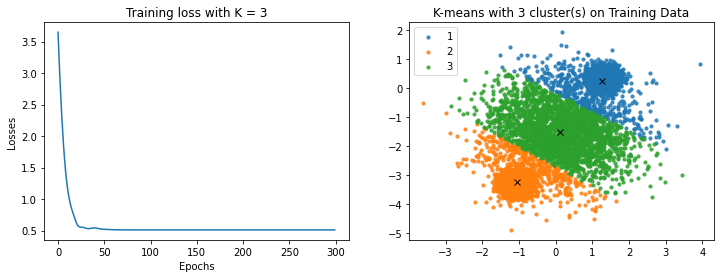

In [16]:
K = 3

# load training data
train_data = load_2D(is_valid=False)
[num_pts, dim] = train_data.shape

# get kmeans loss
train_loss, valid_loss, MU = kMeans(K, train_data)
print("MU values: ")
print(MU)
print("\n")

# get clusters
cluster = get_cluster(K, MU, train_data)

# get percentage of each cluster
percentages = get_percentage(K, cluster)

# plotting
plt.figure(figsize=(12,4))

# plotting loss
plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.plot(train_loss)
plt.title('Training loss with K = {}'.format(K))

# plotting scatters
plt.subplot(122)
for i in range(K):
  x ,y = cluster[i][:, 0], cluster[i][:, 1]
  
  # print percentage of each cluster
  print("Cluster {} Percentage: {:.2%}".format(i + 1,percentages[i]))

  plt.scatter(x, y, s=10, alpha=0.8, label=str(i+1) )  

plt.plot(MU[:, 0], MU[:, 1], 'x', color='black')
plt.title('K-means with {} cluster(s) on Training Data'.format(K))
plt.legend()

plt.show()

K = 1
Training Cluster 1 Percentage: 100.00%
Validation Cluster 1 Percentage: 100.00%


Final Training Loss: 3.8381579392667518
Final Validation Loss: 3.861417348035353


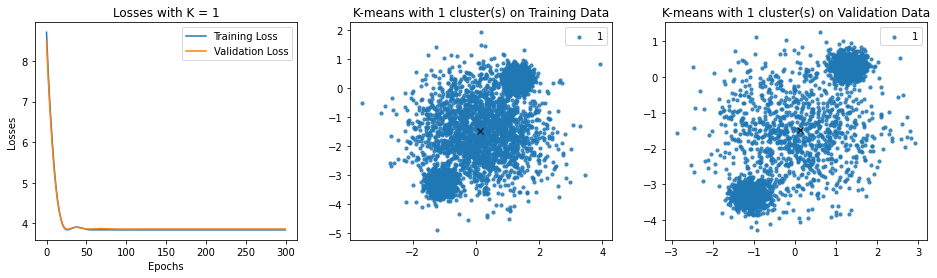

K = 2
Training Cluster 1 Percentage: 50.19%
Validation Cluster 1 Percentage: 48.18%
Training Cluster 2 Percentage: 49.81%
Validation Cluster 2 Percentage: 51.82%


Final Training Loss: 0.9364531984450563
Final Validation Loss: 0.8882906889631942


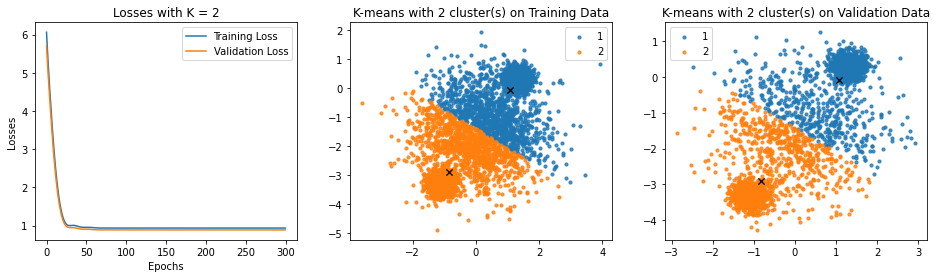

K = 3
Training Cluster 1 Percentage: 38.41%
Validation Cluster 1 Percentage: 37.35%
Training Cluster 2 Percentage: 37.51%
Validation Cluster 2 Percentage: 39.78%
Training Cluster 3 Percentage: 24.07%
Validation Cluster 3 Percentage: 22.86%


Final Training Loss: 0.5233501591812055
Final Validation Loss: 0.4888417204309686


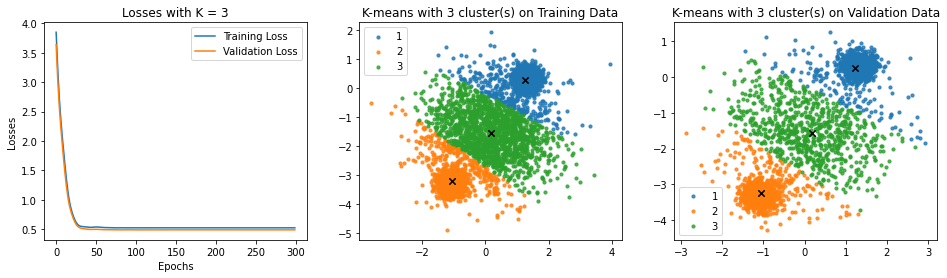

K = 4
Training Cluster 1 Percentage: 13.72%
Validation Cluster 1 Percentage: 12.66%
Training Cluster 2 Percentage: 37.66%
Validation Cluster 2 Percentage: 36.57%
Training Cluster 3 Percentage: 12.31%
Validation Cluster 3 Percentage: 11.97%
Training Cluster 4 Percentage: 36.30%
Validation Cluster 4 Percentage: 38.79%


Final Training Loss: 0.34800652675894916
Final Validation Loss: 0.3164309451108211


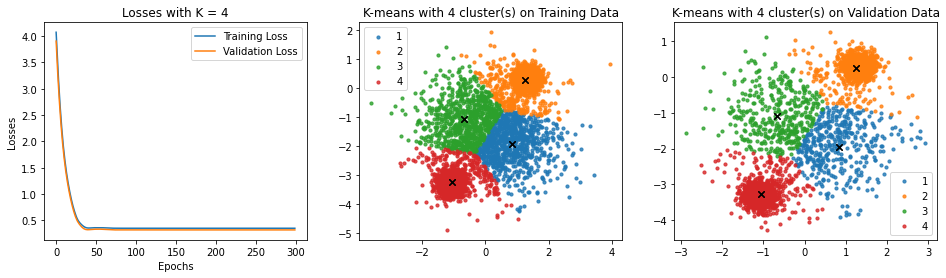

K = 5
Training Cluster 1 Percentage: 12.03%
Validation Cluster 1 Percentage: 11.10%
Training Cluster 2 Percentage: 8.20%
Validation Cluster 2 Percentage: 8.52%
Training Cluster 3 Percentage: 36.10%
Validation Cluster 3 Percentage: 35.13%
Training Cluster 4 Percentage: 35.53%
Validation Cluster 4 Percentage: 37.77%
Training Cluster 5 Percentage: 8.13%
Validation Cluster 5 Percentage: 7.47%


Final Training Loss: 0.294180328215013
Final Validation Loss: 0.275714554056248


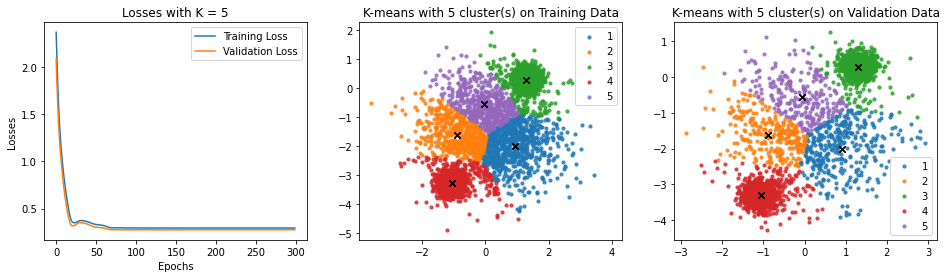

In [17]:
# load training and validation data 
train_data, valid_data = load_2D(is_valid=True)

# train K-means model for 1,2,3,4,5
for K in range(1,6):
  print("K = {}".format(K))

  # compute k-means
  train_loss, valid_loss, MU = kMeans(K, train_data, valid_data, is_valid=True)

  # get clusters
  train_cluster = get_cluster(K, MU, train_data)
  valid_cluster = get_cluster(K, MU, valid_data)

  # get percentage of each cluster
  train_percentages = get_percentage(K, train_cluster)
  valid_percentages = get_percentage(K, valid_cluster)

  # plotting
  fig, ax = plt.subplots(1, 3, figsize=(16,4))

  # plotting loss
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Losses')
  ax[0].plot(train_loss, label = "Training Loss")
  ax[0].plot(valid_loss, label = "Validation Loss")
  ax[0].set_title('Losses with K = {}'.format(K))
  ax[0].legend()

  # plotting scatters
  for i in range(K):
    train_x, train_y = train_cluster[i][:, 0], train_cluster[i][:, 1]
    valid_x, valid_y = valid_cluster[i][:, 0], valid_cluster[i][:, 1]

    # print percentage of each cluster
    print("Training Cluster {} Percentage: {:.2%}".format(i + 1,train_percentages[i]))
    print("Validation Cluster {} Percentage: {:.2%}".format(i + 1,valid_percentages[i]))

    # plot training scatter
    ax[1].scatter(train_x, train_y, s=10, alpha=0.8, label=str(i+1) )
    ax[1].plot(MU[:, 0], MU[:, 1], 'x', color='black')
    ax[1].set_title('K-means with {} cluster(s) on Training Data'.format(K))
    ax[1].legend()

    # plot validation scatter
    ax[2].scatter(valid_x, valid_y, s=10, alpha=0.8, label=str(i+1) )  
    ax[2].plot(MU[:, 0], MU[:, 1], 'x', color='black')
    ax[2].set_title('K-means with {} cluster(s) on Validation Data'.format(K))
    ax[2].legend()

  print("\n")
  print("Final Training Loss: {}".format(train_loss[-1]))
  print("Final Validation Loss: {}".format(valid_loss[-1]))


  plt.show()

In [18]:
import math

def log_gauss_pdf(X, mu, sigma):
    """ Inputs: 
            X: N X D
            mu: K X D
            sigma: K X 1

        Outputs:
            log Gaussian PDF (N X K)
    """
    num_pts, dim = X.shape
    
    try:
      dim = dim.value
    except:
      pass

    const = - (dim / 2) * tf.log(2 * math.pi * tf.transpose(sigma) ** 2)
    pair_dist = distance_func(X, mu)
    exp = - tf.divide(pair_dist, 2 * tf.transpose(sigma) ** 2)
    
    return tf.add(const, exp)


def log_posterior(log_PDF, log_pi):
    """ Inputs:
            log_PDF: log Gaussian PDF N X K
            log_pi: K X 1

        Outputs
            log_post: N X K
    """
    
    numerator_log = tf.add(log_PDF, tf.transpose(log_pi))
    denominator_log = - reduce_logsumexp(numerator_log, 1, keep_dims=True)
    return tf.add(numerator_log, denominator_log)

In [19]:
def find_GMM_loss(pdf, prob):
  likelihood = reduce_logsumexp(pdf + tf.transpose(prob), 1)
  return - tf.reduce_sum(likelihood, axis=0)

def get_GMM_cluster(K, X, MU, log_pi, sigma):
   # getting posterior distribution
    pdf = tf.Session().run(log_gauss_pdf(X, MU, sigma))
    log_post = tf.Session().run(log_posterior(pdf, log_pi))
    
    # getting most likely cluster by index
    index = np.argmax(log_post, axis=1)

    # getting list of actual data grouped by cluster
    cluster = K * [None]
    for i in range(K):
        cluster[i] = X[index == i] 

    return cluster

def GMM(K, train_data, valid_data=None, is_valid=False):
  [num_pts, dim] = train_data.shape

  X = tf.placeholder(tf.float64, [None, dim])
  MU = tf.Variable(tf.truncated_normal([K, dim], dtype=tf.float64))
  phi = tf.Variable(tf.truncated_normal([K, 1], dtype=tf.float64))
  psi = tf.Variable(tf.truncated_normal([K, 1], dtype=tf.float64)) 

  sigma = tf.exp(phi) 
  log_pi = logsoftmax(psi)  

  pdf = log_gauss_pdf(X, MU, sigma)  

  # find loss
  loss = find_GMM_loss(pdf, log_pi)

  # adam optimizer
  adam_op = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)
  
  train_loss = []
  valid_loss = []

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
  
    # append losses
    for i in range(300):

      sess.run(adam_op, feed_dict={X: train_data})
      train_loss.append(sess.run(loss, feed_dict={X: train_data}))
  
      if is_valid:
        valid_loss.append(sess.run(loss, feed_dict={X: valid_data}))
        
    MUs, sigmas, log_pis = sess.run([MU, sigma, log_pi], feed_dict={X: train_data})

  train_loss = np.array(train_loss) / train_data.shape[0]

  if is_valid:
    valid_loss = np.array(valid_loss) / valid_data.shape[0]

  return train_loss, valid_loss, MUs, sigmas, log_pis 

In [ ]:
K = 3

# load training data
train_data = load_2D(is_valid=False)
[num_pts, dim] = train_data.shape

# get GMM loss
train_loss, valid_loss, MU, sigma, log_pi = GMM(K, train_data)

# get clusters
clusters = get_GMM_cluster(K, train_data, MU, log_pi, sigma)

# get percentage of each cluster
percentages = get_percentage(K, clusters)

# plotting
plt.figure(figsize=(12,4))

# plotting loss
plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.plot(train_loss)
plt.title('Training loss with K = {}'.format(K))

# plotting scatters
plt.subplot(122)
for i in range(K):
  x , y = clusters[i][:, 0], clusters[i][:, 1]
  
  # print percentage of each clusters
  print("Clusters {} Percentage: {:.2%}".format(i + 1,percentages[i]))

  plt.scatter(x, y, s=10, alpha=0.8, label=str(i+1) )  

plt.plot(MU[:, 0], MU[:, 1], 'x', color='black')
plt.title('MoG with {} Cluster(s) on Validation Data'.format(K))
plt.legend()

plt.show()

In [ ]:
# load training and validation data 
train_data, valid_data = load_2D(is_valid=True)

# train MoG model for 1,2,3,4,5
for K in range(1,6):
  print("K = {}".format(K))

  # compute losses
  train_loss, valid_loss, MU, sigma, log_pi= GMM(K, train_data, valid_data, is_valid=True)

  # get clusters
  train_cluster = get_GMM_cluster(K, train_data, MU, log_pi, sigma)
  valid_cluster = get_GMM_cluster(K, valid_data, MU, log_pi, sigma)

  # get percentage of each cluster
  train_percentages = get_percentage(K, train_cluster)
  valid_percentages = get_percentage(K, valid_cluster)

  # plotting
  fig, ax = plt.subplots(1, 3, figsize=(16,4))

  # plotting loss
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Losses')
  ax[0].plot(train_loss, label = "Training Loss")
  ax[0].plot(valid_loss, label = "Validation Loss")
  ax[0].set_title('Losses with K = {}'.format(K))
  ax[0].legend()

  # plotting scatters
  for i in range(K):
    train_x, train_y = train_cluster[i][:, 0], train_cluster[i][:, 1]
    valid_x, valid_y = valid_cluster[i][:, 0], valid_cluster[i][:, 1]

    # print percentage of each cluster
    print("Training Cluster {} Percentage: {:.2%}".format(i + 1,train_percentages[i]))
    print("Validation Cluster {} Percentage: {:.2%}".format(i + 1,valid_percentages[i]))

    # plot training scatter
    ax[1].scatter(train_x, train_y, s=10, alpha=0.8, label=str(i+1) )
    ax[1].plot(MU[:, 0], MU[:, 1], 'x', color='black')
    ax[1].set_title('MoG with {} Cluster(s) on Training Data'.format(K))
    ax[1].legend()

    # plot validation scatter
    ax[2].scatter(valid_x, valid_y, s=10, alpha=0.8, label=str(i+1) )  
    ax[2].plot(MU[:, 0], MU[:, 1], 'x', color='black')
    ax[2].set_title('MoG with {} Cluster(s) on Validation Data'.format(K))
    ax[2].legend()

  print("Final Training Loss: {}".format(train_loss[-1]))
  print("Final Validation Loss: {}".format(valid_loss[-1]))

  plt.show()

In [ ]:
# getting data
train_data, valid_data = load_100D(is_valid=True)

# iterate K over 5, 10, 15, 20 , 30
for K in [5, 10, 15, 20, 30]:
    print("K = {}".format(K))
    
    # compute models
    Kmeans_train_loss, Kmeans_valid_loss, MU = kMeans(K, train_data, valid_data,is_valid=True)
    MoG_train_loss, MoG_valid_loss, MU , sigma, log_pi= GMM(K, train_data, valid_data, is_valid=True)
    
    print("K-Means Final Training Loss  : {}".format(Kmeans_train_loss[-1]))
    print("MoG Final Training Loss      : {}".format(MoG_train_loss[-1]))
    print("K-Means Final Validation Loss: {}".format(Kmeans_valid_loss[-1]))
    print("MoG Final Validation Loss    : {}".format(MoG_valid_loss[-1]))
    
    # plotting 
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # plotting losses
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Losses')
    ax[0].plot(Kmeans_train_loss, label = "Training Loss")
    ax[0].plot(Kmeans_valid_loss, label = "Validation Loss")
    ax[0].set_title('Kmean Losses with K = {}'.format(K))
    ax[0].legend()

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Losses')
    ax[1].plot(MoG_train_loss, label = "Training Loss")
    ax[1].plot(MoG_valid_loss, label = "Validation Loss")
    ax[1].set_title('MoG Losses with K = {}'.format(K))
    ax[1].legend()
    plt.show()